In [3]:
#import libraries and functions to load the data
from matplotlib import pyplot as plt

import os
import time

import numpy as np
import torch
import torch.nn.functional as F
import torchvision

from torchvision import transforms, datasets
from torch.utils.data.dataset import random_split
from torchvision.datasets import ImageFolder

from torch.utils.data import DataLoader

from PIL import Image

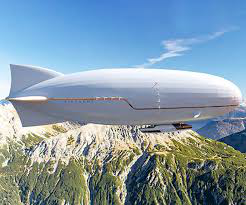

In [5]:
from torchvision import transforms

img_path = 'dataset\\airship\\1.jpg'
img = Image.open(img_path)
img

In [2]:
#for nvidia 
has_gpu = torch.cuda.is_available()
#for mac
has_mps = getattr(torch,'has_mps',False)
device = "mps" if getattr(torch,'has_mps',False) \
    else "cuda" if torch.cuda.is_available() else "cpu"

print("GPU is", "available" if has_gpu else "NOT AVAILABLE")
print("MPS (Apple Metal) is", "AVAILABLE" if has_mps else "NOT AVAILABLE")
print(f"Target device is {device}")

## Some Hyperparameters 
random_seed = 1
batch_size = 128
learning_rate = 0.01
num_epochs = 15
num_classes = 10

GPU is available
MPS (Apple Metal) is NOT AVAILABLE
Target device is cuda


In [ ]:
from torchvision import transforms, datasets
from torch.utils.data.dataset import random_split
from torchvision.datasets import ImageFolder

train_data_transform = transforms.Compose(
    [
        transforms.Resize(32),
        transforms.RandomCrop((28,28)),
        transforms.ToTensor(),
        transforms.Normalize(0.5,0.5)
    ]
)
test_data_transform = transforms.Compose(
    [
        transforms.Resize(32),
        transforms.CenterCrop((28,28)),
        transforms.ToTensor(),
        transforms.Normalize(0.5,0.5)
    ]
)

In [ ]:
#import libraries and functions to load the data
from matplotlib import pyplot as plt

import os
import time
import random
import numpy as np
import torch
import torch.nn.functional as F
import torchvision




#import libraries and functions to load the data
from matplotlib import pyplot as plt

import os
import time

import numpy as np
import torch
import torch.nn.functional as F
import torchvision

from torchvision import transforms, datasets
from torch.utils.data.dataset import random_split
from torchvision.datasets import ImageFolder

from torch.utils.data import DataLoader


In [ ]:
#for nvidia 
has_gpu = torch.cuda.is_available()
#for mac
has_mps = getattr(torch,'has_mps',False)
device = "mps" if getattr(torch,'has_mps',False) \
    else "cuda" if torch.cuda.is_available() else "cpu"

print("GPU is", "available" if has_gpu else "NOT AVAILABLE")
print("MPS (Apple Metal) is", "AVAILABLE" if has_mps else "NOT AVAILABLE")
print(f"Target device is {device}")

## Some Hyperparameters 
random_seed = 1
batch_size = 256
learning_rate = 0.01
num_epochs = 100
num_classes = 6


In [ ]:
import torchvision.transforms as transforms
import torchvision.datasets as datasets

transform = transforms.Compose([
    transforms.Resize(500),
    transforms.CenterCrop(450),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the images from the folder
dataset = datasets.ImageFolder(root=f'{os.getcwd()}/dataset/', transform=transform)

# Create a data loader
loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)


In [ ]:
num_data = len(dataset)
indices = list(range(num_data))
split1 = int(np.floor(0.6 * num_data))
split2 = int(np.floor(0.8 * num_data))
random.shuffle(indices)
train_idx, valid_idx, test_idx = indices[:split1], indices[split1:split2], indices[split2:]

train_subset = torch.utils.data.sampler.SubsetRandomSampler(train_idx)
valid_subset = torch.utils.data.sampler.SubsetRandomSampler(valid_idx)
test_subset = torch.utils.data.sampler.SubsetRandomSampler(test_idx)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=32, sampler=train_subset)
valid_loader = torch.utils.data.DataLoader(dataset, batch_size=32, sampler=valid_subset)
test_loader = torch.utils.data.DataLoader(dataset, batch_size=32, sampler=test_subset)

In [ ]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)
for params in model.parameters():
    params.requires_gradient = False

model.fc = torch.nn.Linear(in_features=2048, out_features=num_classes)
model.eval()

In [ ]:
model.fc.requires_gradient = True
model.avgpool.requires_gradient = True

In [ ]:
def accuracy(model, data_loader, device):
    with torch.no_grad():
        model = model.train()
        true_pred = 0
        tot_samples = 0
        for imgs, labels in data_loader:
            imgs = imgs.to(device)
            labels = labels.to(device)
            logits = model(imgs)
            _, label_pred = torch.max(logits, axis=1)
            true_pred += (label_pred==labels).sum()
            tot_samples += labels.shape[0]
        acc = (true_pred/float(tot_samples))*100
    return acc

In [ ]:
torch.manual_seed(random_seed)
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)
epoch_loss = []

start = time.time()
for epoch in range(num_epochs):
    model = model.train()
    loss_list = []
    for batch_idx, (imgs, labels) in enumerate(train_loader):
        imgs = imgs.to(device)
        labels = labels.to(device)
        
        ## Forward Propagation - extract features and classify
        logits = model(imgs)
        loss = F.cross_entropy(logits, labels)
        
        loss_list.append(float(loss))

        #zero out the gradients
        optimizer.zero_grad()
        #estimate new gradients
        loss.backward()
        #update parameters
        optimizer.step()
        
        if not (batch_idx + 1) % 100:
            print(
                f"Epoch: {epoch + 1:03d}/{num_epochs:03d} | "
                f"Batch: {batch_idx + 1:03d}/{len(train_loader):03d} | "
                f"Loss: {loss:.4f}"
            )
    mean_loss = round(np.mean(loss_list),5)
    epoch_loss.append(mean_loss)
    # Tracking the Learning Rate Scheduler
    prev_lr = optimizer.param_groups[0]["lr"]
    scheduler.step()
    current_lr = optimizer.param_groups[0]["lr"]
    print(f"Epoch: {epoch+1:03d} Learning Rate {prev_lr:.8f} -> {current_lr:.8f}")


    # Evaluate Performance after each epoch
    model = model.eval()
    tr_acc = accuracy(model, train_loader, device)
    valid_acc = accuracy(model, valid_loader, device)
    print(f"Train Accuracy: {tr_acc:0.3f}")
    print(f"Validation Accuracy: {valid_acc:0.3f}")
    print(f"Time elapsed so far: {(time.time() - start) / 60:.2f} min\n")

print(f"Total Train Time: {(time.time() - start) / 60:.2f} min")
